### More In-Depth Visualization of Data

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D


In [3]:
# import cartesian dataframe
df = pd.read_csv('data/monte_carlo_cartesian.csv')
pd.set_option('display.width', 180)

print(df)

    HVS            source_id          x     x_err          y      y_err          z      z_err            u       u_err           v       v_err           w       w_err
0     1   577294697514301440 -67.167129  8.694265 -64.213766   9.455331  53.333888   7.850231  -565.615243  212.179615 -447.070697  144.860803  126.327510  236.553614
1     4   699811079173836928 -53.352016  6.863052 -11.944270   1.812383  43.194513   6.551032  -427.688594   54.695063  -43.340020   63.031493  351.700045   58.447353
2     5  1069326945513133952 -36.784355  3.206906  19.215101   2.149892  27.783766   3.106274  -401.048377   16.147501  295.590741   30.245039  415.734202   16.696836
3     6  3867267443277880320 -20.679576  1.560496 -25.012221   3.108195  47.768181   5.933426  -111.918159   71.072132    6.487129   56.828133  555.781066   37.682558
4     7  3799146650623432704 -10.989768  0.342456 -27.590526   3.294710  44.344924   5.292946   -37.522684   39.930514  -38.481590   31.053835  449.190377   20.42711

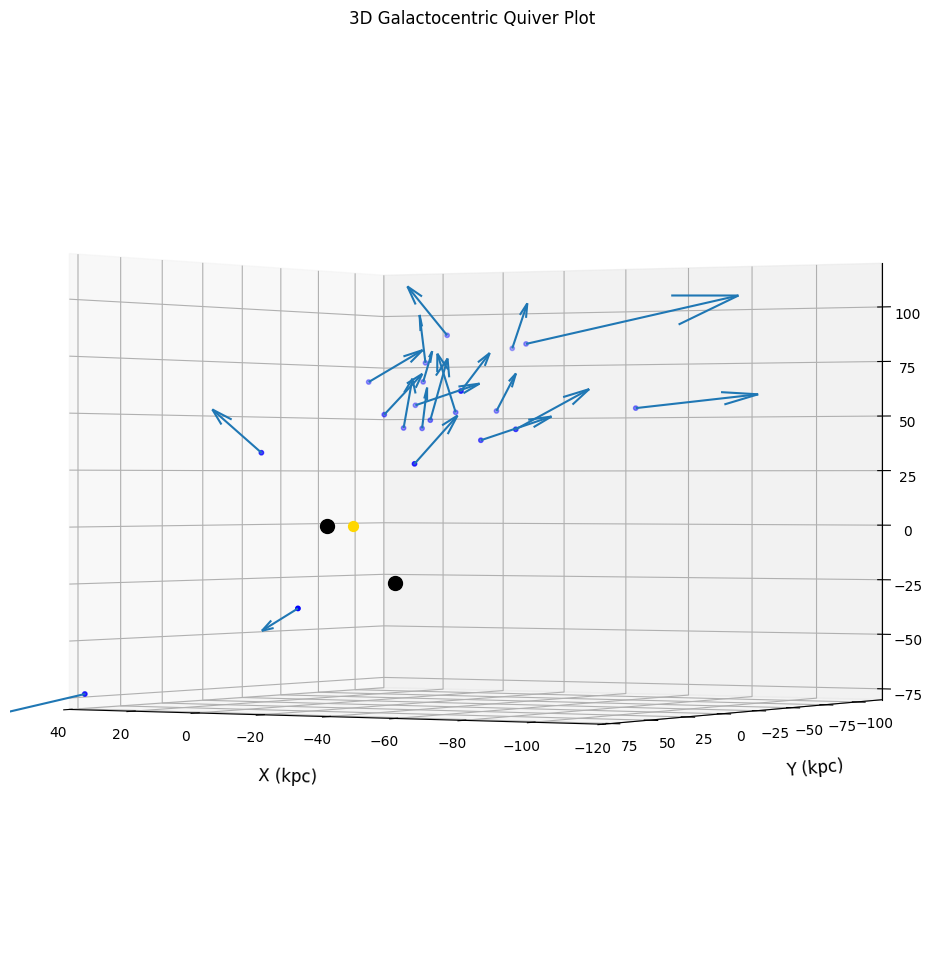

In [ ]:
# 3d galactocentric quiver plot
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')

quiver = ax.quiver(
    df['x'], df['y'], df['z'],
    df['u'], df['v'], df['w'],
    length = 0.05,
    label="HVS and Velocity Vectors"
)
# HVS positions
ax.scatter(df['x'], df['y'], df['z'], color='blue', s=10, label='HVS Positions')
# Galactic Center
ax.scatter(0,0,0, color='black', s=100, label='Saggitarius A*')
# Sun
ax.scatter(-8.2, 0, 0.02, color='gold', s=50, label='Sun')
# LMC*
ax.scatter(-1.5, -41.4, -26.7, color='black', s=100, label='LMC*')

ax.set_xlabel('X (kpc)', fontsize=12, labelpad=20)
ax.set_ylabel('Y (kpc)', fontsize=12, labelpad=20)
ax.set_zlabel('Z (kpc)', fontsize=12, labelpad=20)
ax.set_xlim([-120, 40])
ax.set_ylim([-120, 80])
ax.set_zlim([-80, 120])

ax.set_title('3D Galactocentric Quiver Plot')
ax.view_init(elev=0., azim=120)
plt.show()

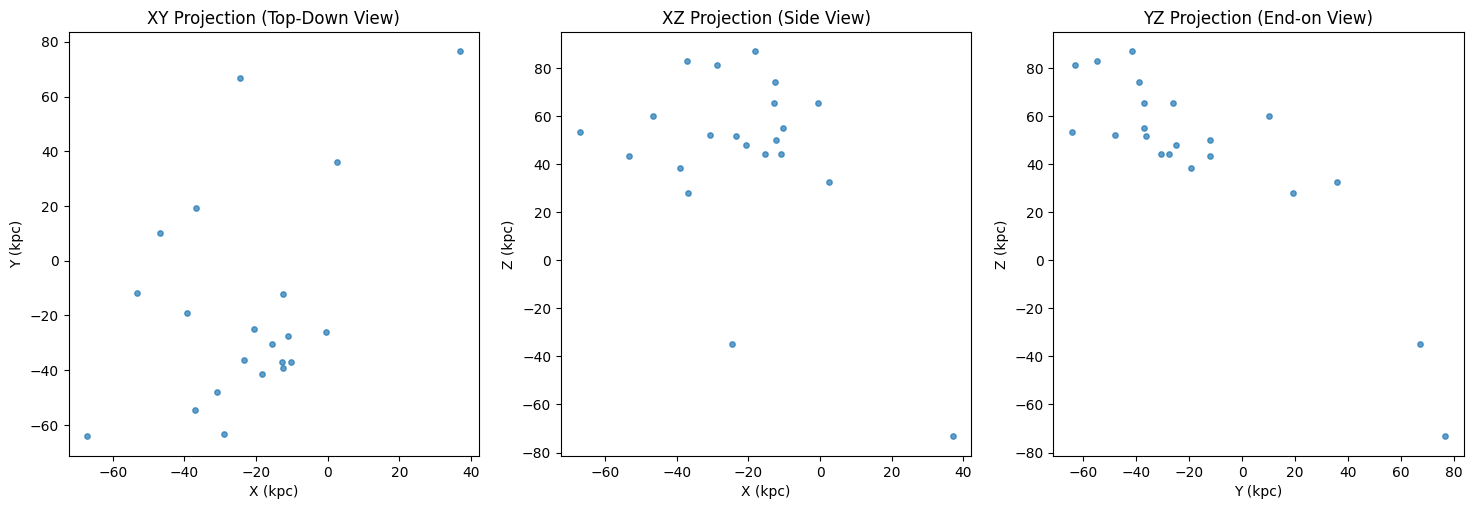

In [36]:
# xz, yz, xy plots of HVS in galactocentric frame
x = df['x']
y = df['y']
z = df['z']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5.5))
ax1.scatter(x, y, s=15, alpha=0.7)
ax1.set_title('XY Projection (Top-Down View)')
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')

ax2.scatter(x, z, s=15, alpha=0.7)
ax2.set_title('XZ Projection (Side View)')
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Z (kpc)')

ax3.scatter(y, z, s=15, alpha=0.7)
ax3.set_title('YZ Projection (End-on View)')
ax3.set_xlabel('Y (kpc)')
ax3.set_ylabel('Z (kpc)')

plt.show()


In [ ]:
# energy vs angular momentum plot
import gala.potential as gp
import gala.dynamics as gd



In [42]:
# aitoff projection using original RA, Dec values
df = pd.read_csv('data/gaia_data.csv')
icrs_coords = SkyCoord(frame='icrs', ra=df['ra'], dec=df['dec'])
print(icrs_coords)

UnitTypeError: Longitude instances require units equivalent to 'rad', but no unit was given.